In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D, Dropout, MaxPooling2D, Input, Lambda, BatchNormalization
from keras import backend as k
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import pandas as pd
from PIL import Image
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split

In [3]:
def read_data(file_path):
  imgs = []
  files =Path(file_path).glob('*')
  for myFile in files:
      img=Image.open(myFile)
      img = img.convert('RGB')
      img=img.resize((128,128))
      if 'Essam' in file_path:
        img=img.rotate(90)
      if 'Shafiq' in file_path:
        img=img.rotate(90)
      img=np.array(img)
      img = img/255.0
      imgs.append(img)

  return np.array(imgs)


essam = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Essam')
hossam = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Hossam')
hussein = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Hussein')
mariam = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Mariam ')
ibrahim = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Ibrahim')
abdelrashied = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/AbdelRashied')
bassant = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Bassant')
shafiq = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Shafiq')
aya = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Aya')
menna = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Menna ')
yasmine = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Yasmine')
dynamo = read_data('/content/drive/MyDrive/NTI Face Recognition Dataset/Dynamo')



In [4]:
data = np.concatenate([essam, hossam, hussein, mariam, ibrahim, abdelrashied, bassant, shafiq, aya, menna, yasmine, dynamo])
target = np.concatenate([[0]*essam.shape[0], [1]*hossam.shape[0], [2]*hussein.shape[0], [3]*mariam.shape[0], [4]*ibrahim.shape[0], [5]*abdelrashied.shape[0], [6]*bassant.shape[0], [7]*shafiq.shape[0], [8]*aya.shape[0], [9]*menna.shape[0], [10]*yasmine.shape[0], [11]*dynamo.shape[0]])

In [5]:
data.shape

(180, 128, 128, 3)

In [6]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])

    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

images_pair, labels_pair = generate_train_image_pairs(data, target)

In [7]:
images_pair.shape, labels_pair.shape

((360, 2, 128, 128, 3), (360,))

In [8]:
labels_pair = labels_pair*1.0

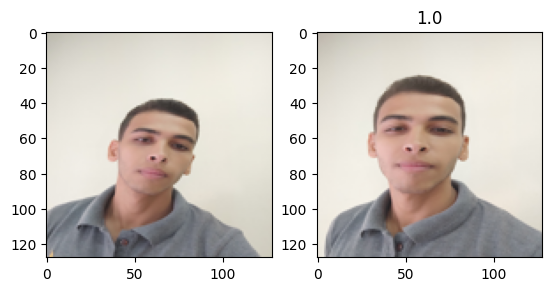

<Figure size 640x480 with 0 Axes>

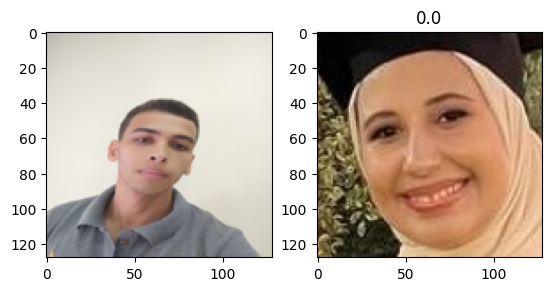

<Figure size 640x480 with 0 Axes>

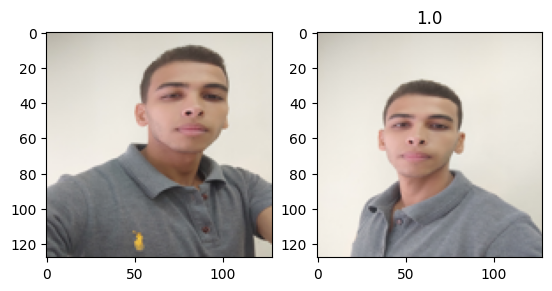

<Figure size 640x480 with 0 Axes>

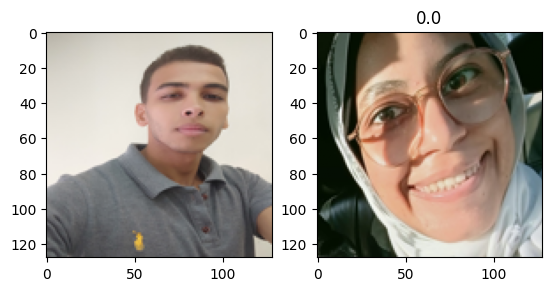

<Figure size 640x480 with 0 Axes>

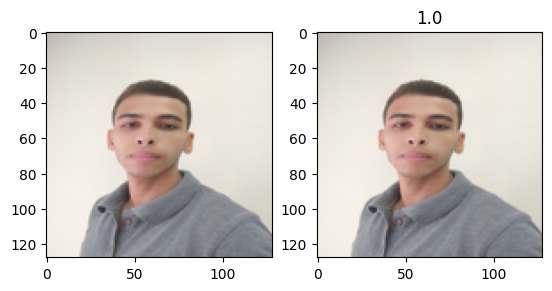

<Figure size 640x480 with 0 Axes>

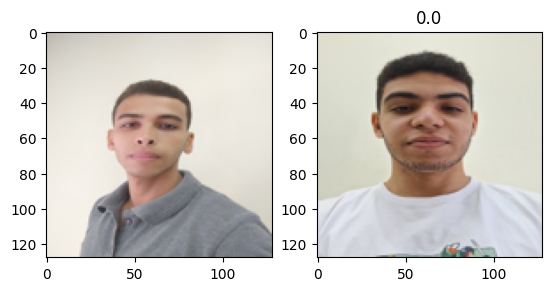

<Figure size 640x480 with 0 Axes>

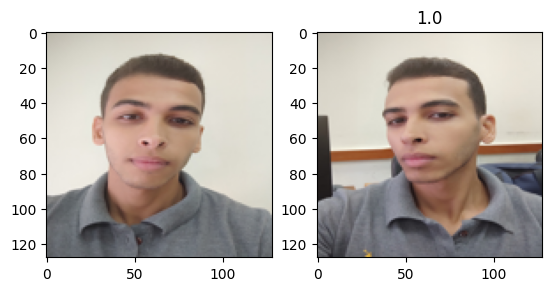

<Figure size 640x480 with 0 Axes>

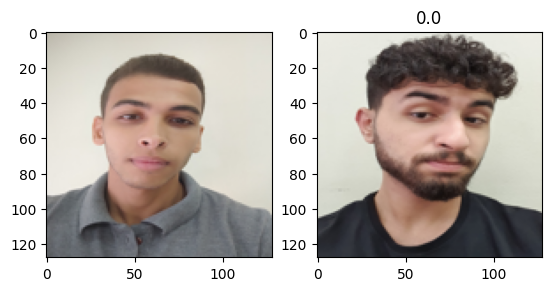

<Figure size 640x480 with 0 Axes>

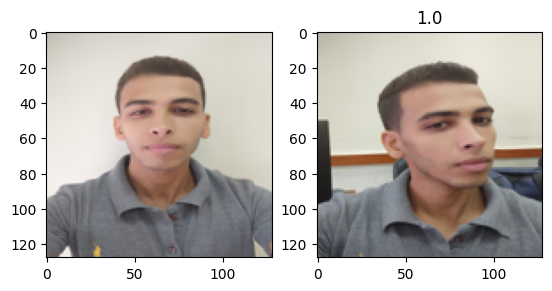

<Figure size 640x480 with 0 Axes>

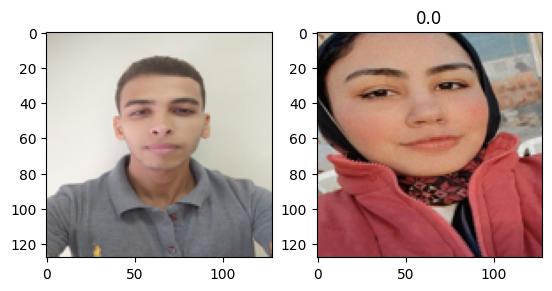

<Figure size 640x480 with 0 Axes>

In [9]:
for pair, label in zip(images_pair[:10], labels_pair[:10]):
        pair_image1 = pair[0]
        pair_image1 = np.expand_dims(pair_image1, axis=0)
        pair_image2 = pair[1]
        pair_image2 = np.expand_dims(pair_image2, axis=0)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(pair_image1[0])
        axarr[1].imshow(pair_image2[0])
        plt.title(label)
        plt.figure()

In [ ]:
# Base network architecture

inputs = Input((128, 128, 3))
x = Conv2D(96, (3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(256, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(512, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(1024, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(2048, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

pooledOutput = Flatten()(x)
outputs = Dense(128, activation="relu")(pooledOutput)

base_model = keras.Model(inputs, outputs)
base_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 96)      2688      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 96)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 96)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 256)       221440    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                       

In [ ]:
imgA = Input(shape=(128,128, 3))
imgB = Input(shape=(128,128, 3))
featA = base_model(imgA)
featB = base_model(imgB)

In [ ]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 128)          26049024    ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

In [11]:
# def eucl_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)

# def contrastive_loss_with_margin(margin=1):
#     def contrastive_loss(y_true, y_pred):
#         square_pred = k.square(y_pred)
#         margin_square = k.square(k.maximum(margin - y_pred, 0))
#         return (y_true * square_pred + (1 - y_true) * margin_square)
#     return contrastive_loss

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = k.square(y_pred)
        margin_square = k.square(k.maximum(margin - y_pred, 0))
        loss = k.mean((1 - y_true) * square_pred + y_true * margin_square)

        return loss

    return contrastive_loss

In [ ]:
model.compile(loss=contrastive_loss_with_margin(0.5), optimizer=keras.optimizers.Adam())

In [ ]:
from keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Train the model with early stopping
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:], validation_split=0.1,
                    epochs=200, shuffle=1, batch_size=16, callbacks=[early_stopping])

Epoch 1/200
21/21 [==============================] - 7s 178ms/step - loss: 0.0900 - val_loss: 0.0585
Epoch 2/200
21/21 [==============================] - 3s 157ms/step - loss: 0.0586 - val_loss: 0.0615
Epoch 3/200
21/21 [==============================] - 3s 152ms/step - loss: 0.0548 - val_loss: 0.0421
Epoch 4/200
21/21 [==============================] - 3s 155ms/step - loss: 0.0544 - val_loss: 0.0409
Epoch 5/200
21/21 [==============================] - 3s 156ms/step - loss: 0.0507 - val_loss: 0.0429
Epoch 6/200
21/21 [==============================] - 3s 155ms/step - loss: 0.0477 - val_loss: 0.0400
Epoch 7/200
21/21 [==============================] - 3s 155ms/step - loss: 0.0442 - val_loss: 0.0473
Epoch 8/200
21/21 [==============================] - 3s 154ms/step - loss: 0.0426 - val_loss: 0.0361
Epoch 9/200
21/21 [==============================] - 3s 157ms/step - loss: 0.0366 - val_loss: 0.0400
Epoch 10/200
21/21 [==============================] - 3s 158ms/step - loss: 0.0344 - val_lo

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

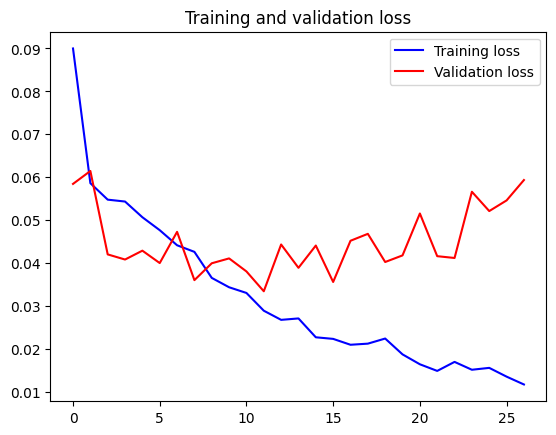

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
# Register the custom loss function
with keras.utils.custom_object_scope({'contrastive_loss': contrastive_loss_with_margin}):
    model = keras.models.load_model('/content/drive/MyDrive/Face Recognition.h5')


In [15]:
#This model predict distance <--->
imgA = Input(shape=(128, 128, 3))
imgB = Input(shape=(128, 128, 3))
modl=model.layers[2](imgA)
modr=model.layers[2](imgB)
dist=model.layers[3]([modl,modr])

encoder=keras.Model([imgA, imgB],dist)

encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 128)          26049024    ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [16]:
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                        label == curr_label])

    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    return np.array(pair_images), np.array(pair_labels)

Label(value='Face Recognition Image:')

FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload')

Button(description='Recognize', style=ButtonStyle())

(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 24ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 25ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 27ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 25ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 24ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 26ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(2, 1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step


<ipython-input-18-c1f76298dbc9>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1,2)


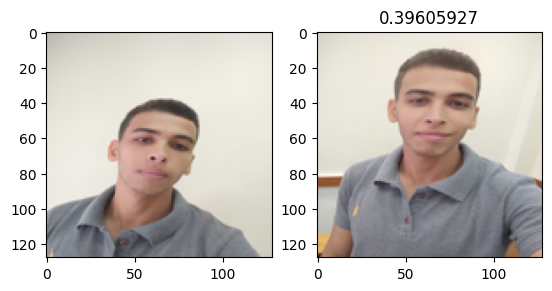

<Figure size 640x480 with 0 Axes>

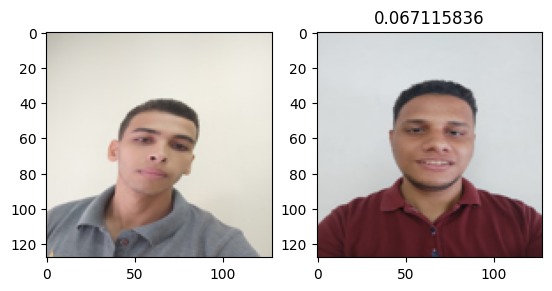

<Figure size 640x480 with 0 Axes>

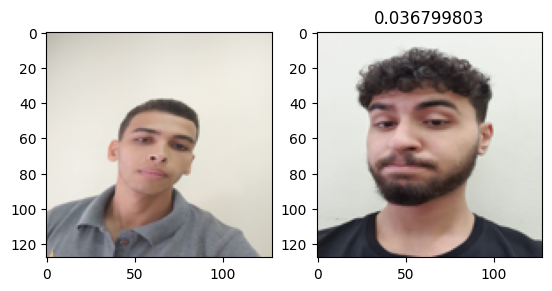

<Figure size 640x480 with 0 Axes>

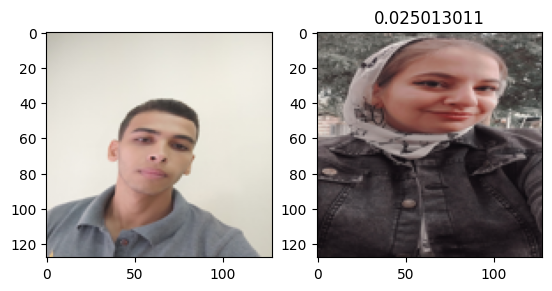

<Figure size 640x480 with 0 Axes>

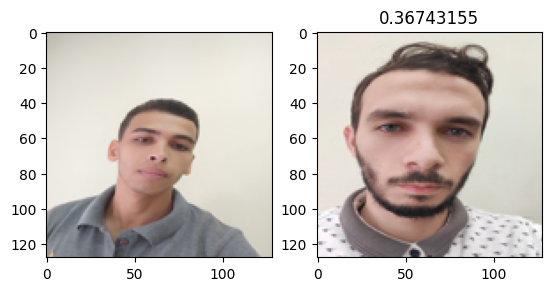

<Figure size 640x480 with 0 Axes>

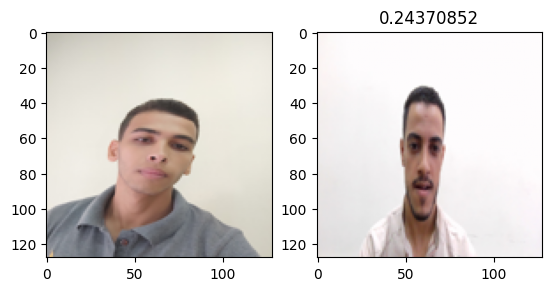

<Figure size 640x480 with 0 Axes>

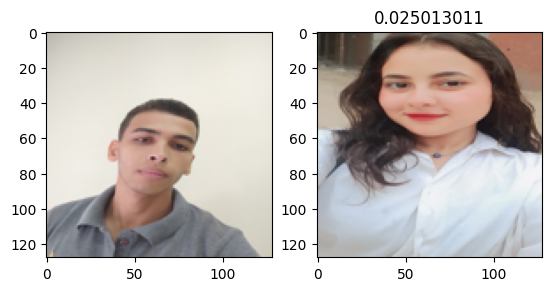

<Figure size 640x480 with 0 Axes>

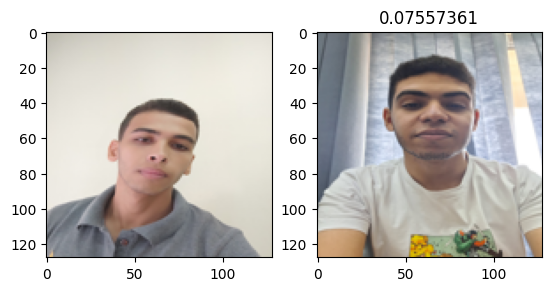

<Figure size 640x480 with 0 Axes>

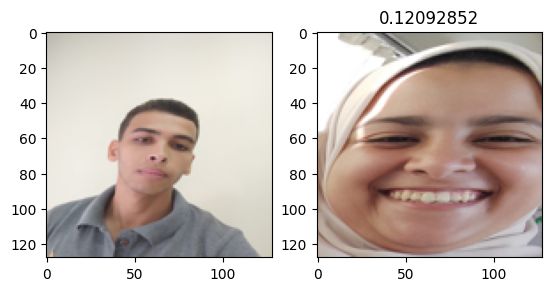

<Figure size 640x480 with 0 Axes>

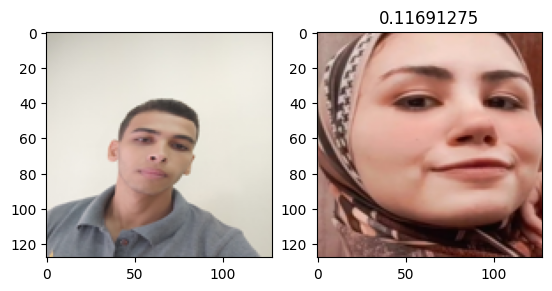

<Figure size 640x480 with 0 Axes>

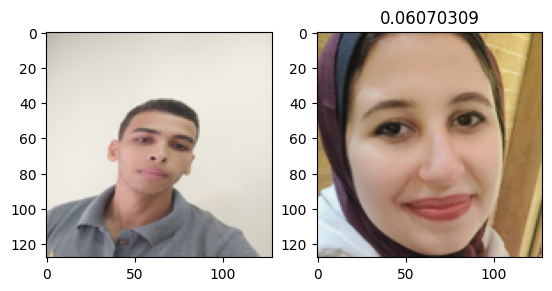

<Figure size 640x480 with 0 Axes>

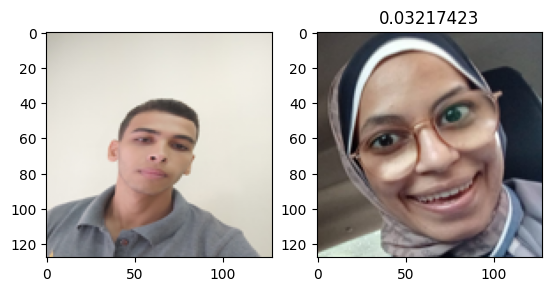

<Figure size 640x480 with 0 Axes>

In [18]:
import io
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import cv2

# Create GUI elements
face_recognition_label = widgets.Label(value="Face Recognition Image:")
face_recognition_upload_test = widgets.FileUpload(accept='.jpg,.jpeg,.png')

recognize_button = widgets.Button(description="Recognize")

# Create a function to handle the signature verification process
def recognize_face(sender):
    # Get the uploaded image
    image_data = list(face_recognition_upload_test.value.values())[0]
    image = Image.open(io.BytesIO(image_data['content'])).convert('RGB').resize((128, 128)).rotate(90)  # Convert to grayscale
    image = np.array(image)/255.0

    test_image_pairs, test_label_pairs = generate_test_image_pairs(data, target, image) # produce an array of test image pairs and test label pairs

    # for each pair in the test image pair, predict the similarity between the images
    for index, pair in enumerate(test_image_pairs):
        # pair_image1 = np.array(pair[0], dtype=np.float32)
        # pair_image1 = pair_image1
        # pair_image2 = np.array(pair[1], dtype=np.float32)
        # pair_image2 = pair_image2

        pair_image1 = pair[0]
        pair_image1 = np.expand_dims(pair_image1, axis=0)
        pair_image2 = pair[1]
        pair_image2 = np.expand_dims(pair_image2, axis=0)
        # Run inference
        print(np.array([pair_image1, pair_image2]).shape)
        #Highest prediction means highest similarity.
        prediction = model.predict([pair_image1, pair_image2])[0][0]
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(pair_image1[0])
        axarr[1].imshow(pair_image2[0])
        plt.title(prediction)
        plt.figure()



# Assign the function to the button's click event
recognize_button.on_click(recognize_face)

# Display the GUI elements
display(face_recognition_label, face_recognition_upload_test, recognize_button)

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('Face_Recognition_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/Face_Recognition___.tflite')
interpreter.allocate_tensors()
# Learn about its input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'name': 'serving_default_input_10:0',
  'index': 0,
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([ -1, 128, 128,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_input_9:0',
  'index': 1,
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([ -1, 128, 128,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 49,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]